# Random Forest Explainer

Random forests are an incredible tool. Their non parametric structure based on the votes of multiple uncorrelated decision trees produces excellent results. However, when it comes to explaining their decisions or predicting their behaviour on novel data they are considered 'black box'.

There are great tools available such as SHAP and LIME that explain models well, however, these require a test set. My intuition tells me there may be methods to direct uncover the workings within the model. After all, the component parts of a random forest classifier are quite simple (multipe <= operations) but quickly grow in complexity.

Regardless of the success, this will be a nice refresher on the inner working of one of the go-to models in machine learning.

Plan:
- Train Random Forest clasifer on a known data set
- For each tree in random forest, extract decision node information
- Compare plots of high/low importance features for
    - impurity (1 - gini)
    - threshold value
    - n samples 


I expect to see:
- Higher importance features having smaller variance in threshold
- Gaussian distribution for thresholds

I am interested in:
- What distinguishes high importance fetaures from low importance ones, in terms of node decisions.
- How can we predict behaviour from 

Questions I have:
- How do we incorporate importance of nodes? gini + sample? simulated descision paths?



In [1]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import _tree
from matplotlib import pyplot as plt
import seaborn as sns
import os
from typing import List, Generator, Any
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [2]:
# Train model
X, y = load_breast_cancer(return_X_y=True)
feature_names = load_breast_cancer()['feature_names']
data = pd.DataFrame(X, columns=feature_names)
data['y'] = y
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)

RandomForestClassifier(max_depth=10, random_state=42)

### Extracting node information

The `RandomForestClassifier` contains multiple `DecisionTreeClassifier` objects that each contain an `sklearn.tree.tree_`. We need to traverse the tree, extracting information when we are at a decision node.

https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html


In [3]:
def extract_tree_data(
    tree_: _tree,
    feature_names: List[str]
) -> Generator[dict, None, None]:
    """ Extracts node information from an `sklearn.tree.tree_`
     It begins at the root node and recursively searches left and right until
     the nodes are depleted.
    """
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    def recurse_node_extract(node, depth):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            class_ = np.argmax(tree_.value[node][0])
            yield {
                'name' : feature_name[node],
                'depth' : depth,
                'threshold' : tree_.threshold[node],
                'n_samples' : tree_.n_node_samples[node],
                'impurity' : tree_.impurity[node],
                'value' : tree_.value[node],
                'max_class' : class_,
                'ratio' : tree_.value[node][0][class_] / np.sum(tree_.value[node][0])
                }
            yield from recurse_node_extract(tree_.children_left[node], depth + 1)
            yield from recurse_node_extract(tree_.children_right[node], depth + 1)
        else:
            pass

    yield from recurse_node_extract(0, 0)

def extract_trees_random_forest(
    rf_classifier: RandomForestClassifier,
    feature_names: List[str]
) -> List[dict]:
    """ Extracts node information from each decision tree estimator
    in a fitted RandomForestClassifier
    """
    return list(
        {**node, **{'tree' : idx}}
        for idx, estimator in enumerate(rf_classifier.estimators_)
        for node in extract_tree_data(estimator.tree_, feature_names)
        )


In [4]:

df = pd.DataFrame(extract_trees_random_forest(rf, feature_names))
df

,name,depth,threshold,n_samples,impurity,value,max_class,ratio,tree
0,worst concave points,0,0.143600,364,0.470162,"[[215.0, 354.0]]",1,0.622144,0
1,mean texture,1,21.305000,244,0.189438,"[[41.0, 346.0]]",1,0.894057,0
2,worst area,2,947.600006,188,0.053831,"[[8.0, 281.0]]",1,0.972318,0
3,perimeter error,3,4.032000,179,0.014234,"[[2.0, 277.0]]",1,0.992832,0
4,worst compactness,4,0.348550,175,0.007326,"[[1.0, 271.0]]",1,0.996324,0
...,...,...,...,...,...,...,...,...,...
2007,mean radius,5,11.285000,16,0.086777,"[[1.0, 21.0]]",1,0.954545,99
2008,mean perimeter,6,68.010002,2,0.444444,"[[1.0, 2.0]]",1,0.666667,99
2009,fractal dimension error,3,0.012350,12,0.332410,"[[15.0, 4.0]]",0,0.789474,99
2010,mean texture,2,14.515000,118,0.010695,"[[185.0, 1.0]]",0,0.994624,99


This is good. We have the decision thresholds for each node within the tree

Now we need to see how this looks for the most impactful feature.

In [5]:
feature_importances = dict(sorted(dict(zip(feature_names, rf.feature_importances_)).items(), key=lambda x: x[1], reverse=True))
list(feature_importances.items())[:10]

[('worst area', 0.13954433384105788),
 ('worst concave points', 0.13269812403958237),
 ('mean concave points', 0.10671683428829666),
 ('worst radius', 0.08261800087740362),
 ('worst perimeter', 0.08110950835143922),
 ('mean perimeter', 0.06816115162380278),
 ('mean concavity', 0.06694279244588956),
 ('mean area', 0.06003327099886618),
 ('worst concavity', 0.037172473849797126),
 ('mean radius', 0.03489330154206888)]

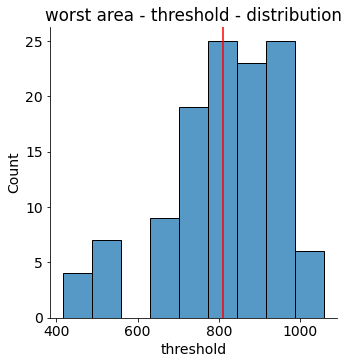

In [6]:
feature = 'worst area'
measure = 'threshold'
plot_df = df.loc[df.name==feature]
sns.displot(data=plot_df, x=measure)
plt.title(f"{feature} - {measure} - distribution")
plt.axvline(x=plot_df[measure].mean(),
            color='red')

This looks promising. We have a normalish distribution around the mean. However, I'm not sure what scale we are looking at. Is 1000 high? Is this very precise? We can plot it along with the data.

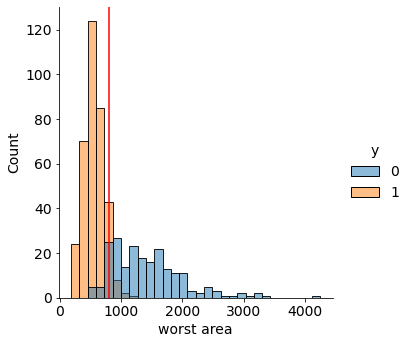

In [7]:
sns.displot(data=data, x=feature, hue="y")
plt.axvline(x=plot_df[measure].mean(),
            color='red')

This is good. We already have some sort of decision boundaries that makes sense with the data. However, I think we can improve

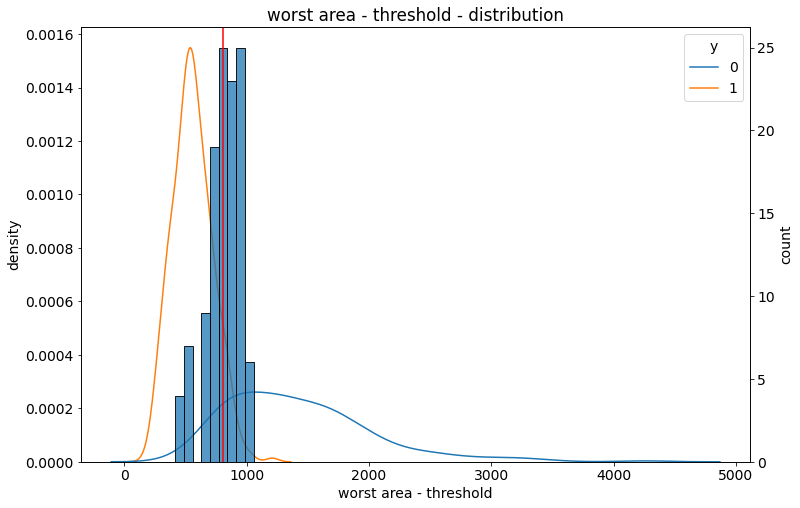

In [8]:
ax = sns.kdeplot(x=data[feature], hue=data["y"])
ax.set(ylabel='density', xlabel=f'{feature} - {measure}')

ax2 = plt.twinx()
ax2 = sns.histplot(x=plot_df[measure],  ax=ax2)
ax2.set_ylabel('count')

plt.title(f"{feature} - {measure} - distribution")
plt.axvline(x=plot_df[measure].mean(), color='red')
plt.show()

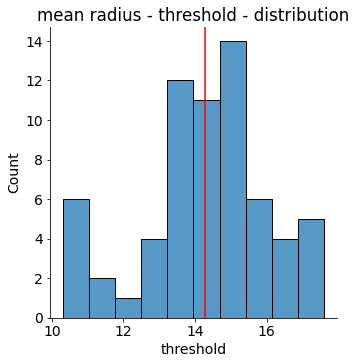

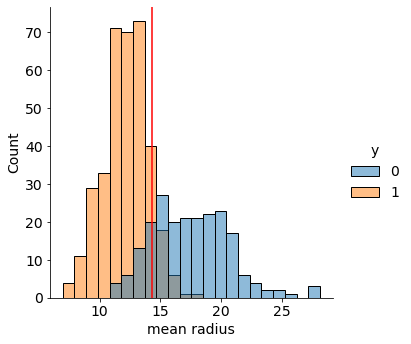

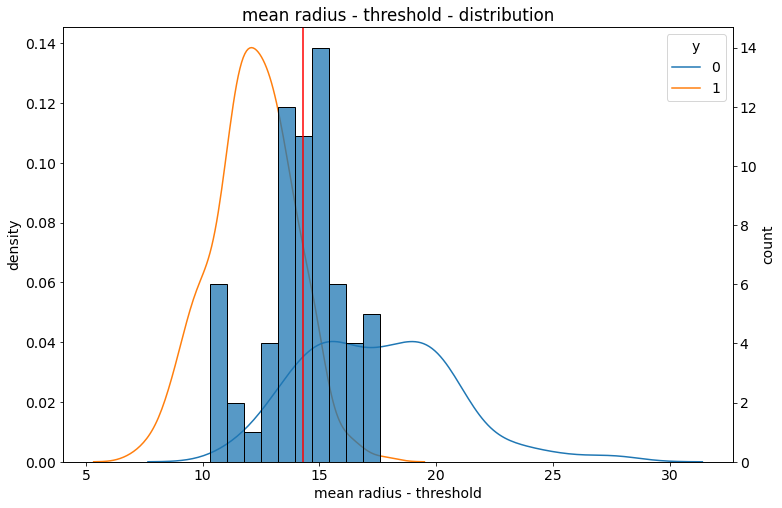

In [9]:
def plot_tree_decisions(df: pd.DataFrame, feature: str) -> None:
        measure = 'threshold'
        plot_df = df.loc[df.name==feature]
        sns.displot(data=plot_df, x=measure)
        plt.title(f"{feature} - {measure} - distribution")
        plt.axvline(x=plot_df[measure].mean(),
                color='red')
        plt.show()

        sns.displot(data=data, x=feature, hue="y")
        plt.axvline(x=plot_df[measure].mean(),
                color='red')
        plt.show()

        ax = sns.kdeplot(x=data[feature], hue=data["y"])
        ax.set(ylabel='density', xlabel=f'{feature} - {measure}')

        ax2 = plt.twinx()
        ax2 = sns.histplot(x=plot_df[measure],  ax=ax2)
        ax2.set_ylabel('count')

        plt.title(f"{feature} - {measure} - distribution")
        plt.axvline(x=plot_df[measure].mean(), color='red')
        plt.show()

plot_tree_decisions(df, "mean radius")

This shows we can extract the decision being made by the trees. To expand on this, I would like to know how this relates to actual predictions. I don't have more data so I'm going to fake it with simulation.

I expect that the prediction probabilities will bein swinging direction around the node threshold values, with the most activity around the mean. Makes sense if these are making the decisions.

In [10]:
feature_range = list(range(300, 2000, 25))
original_prediction_ordered = np.argsort(rf.predict_proba(X)[:, 1])

simulated_results = []
for simulated_value in feature_range:
    sim_X = X.copy()[original_prediction_ordered]
    sim_X[:, list(feature_names).index(feature)] = simulated_value
    simulated_results.append(rf.predict_proba(sim_X)[:, 1])

simulated_results[0][:10]

array([0.18, 0.15, 0.17, 0.13, 0.15, 0.22, 0.15, 0.14, 0.2 , 0.18])

In [11]:

sim_df = (
    pd.DataFrame(np.array(simulated_results), index=feature_range).reset_index()
    .melt(id_vars='index').rename(
        columns={
            'index' : 'feature_value',
            'variable' : 'observation_index',
            'value' : 'predict_proba',
            })
)
sim_df['prediction_index'] = sim_df.assign(count=1).groupby('observation_index').cumsum()['count'] - 1

def is_min(df):
    df['start_value'] = df.loc[df.prediction_index==0, 'predict_proba'].values[0]
    df['end_value'] = df.loc[df.prediction_index==df.prediction_index.max(), 'predict_proba'].values[0]
    df['delta'] = df['end_value'] - df['start_value'] 
    return df

sim_df = sim_df.groupby('observation_index').apply(is_min)
sim_df

,feature_value,observation_index,predict_proba,prediction_index,start_value,end_value,delta
0,300,0,0.18,0,0.18,0.00,-0.18
1,325,0,0.18,1,0.18,0.00,-0.18
2,350,0,0.18,2,0.18,0.00,-0.18
3,375,0,0.18,3,0.18,0.00,-0.18
4,400,0,0.18,4,0.18,0.00,-0.18
...,...,...,...,...,...,...,...
38687,1875,568,0.74,63,1.00,0.74,-0.26
38688,1900,568,0.74,64,1.00,0.74,-0.26
38689,1925,568,0.74,65,1.00,0.74,-0.26
38690,1950,568,0.74,66,1.00,0.74,-0.26


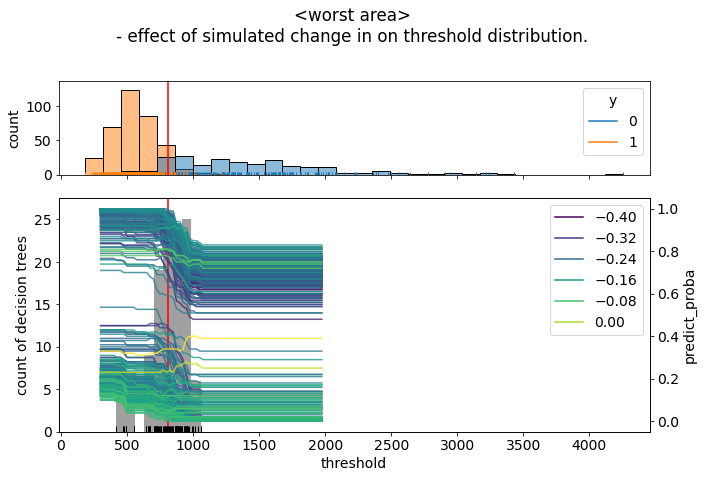

In [12]:
def plot_feature_dist_target(data, feature, mean_line, ax):
    sns.histplot(x=data[feature], hue=data["y"], ax=ax)
    sns.rugplot(x=data[feature],hue=data["y"], color="grey", ax=ax)
    ax.set(ylabel='density')
    ax.axvline(x=mean_line, color='red', label=mean_line)
    ax.set_ylabel('count')

def plot_tree_dist(data, measure, ax):
    sns.histplot(data=data, x=measure, color='grey', ax=ax)
    plt.setp(ax.patches, linewidth=0)
    ax.axvline(x=data[measure].mean(), color='red', label=data[measure].mean())
    sns.rugplot(data=data, x=measure, color="black", ax=ax)
    ax.set_ylabel('count of decision trees')

def plot_simulated_score(data, ax):
    plot = sns.lineplot(
        data=data,
        x='feature_value',
        y="predict_proba",
        hue="delta",
        units="observation_index",
        palette="viridis",
        alpha=0.8,
        estimator=None,
        ax = ax,
    )

def plot_simulated_change(data, rf_df, sim_df, measure, feature, save_location=None):
    fig, (ax, ax2) = plt.subplots(2, figsize=(10,7), sharex=True, gridspec_kw={'height_ratios':[0.8,2]})
    plot_feature_dist_target(data, feature, rf_df[measure].mean(), ax)
    plot_tree_dist(rf_df, measure, ax2)
    ax2_twin = ax2.twinx()
    plot_simulated_score(sim_df, ax2_twin)
    plt.legend(loc='upper right')
    fig.suptitle(t=f"<{feature}>" + f"\n- effect of simulated change in on {measure} distribution.")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    if save_location:
        fname = f"simulated_rf_{feature}.png"
        plt.savefig(os.path.join(save_location, fname),  dpi='figure')
    else:
        plt.show()

plot_simulated_change(data, plot_df, sim_df, 'threshold', 'worst area')

This shows what we expected in drop offs around the mean. I'm interested that it's not everyone - this speaks to the non-parametric nature of the algorithm and gives an opportunity to uncover more about the algorithm's working. Are the yellow lines something we could expect when this model goes into production? Are they bucking the curve for a good reason? These are important questions if this was a product affecting people's lives and a bonus to these having visualisatons.

These could be pulled out in a validation stage to be checked and confirmed. For example, if this was a loan application algorithm, this could be a potential route for abuse.

I'm going to move on to simulating for every feature.

In [329]:

def simulate_results(rf_classifier, X, feature, feature_range):
    original_prediction_ordered = np.argsort(rf_classifier.predict_proba(X)[:, 1])

    simulated_results = []
    for simulated_value in feature_range:
        sim_X = X.copy()[original_prediction_ordered]
        sim_X[:, list(feature_names).index(feature)] = simulated_value
        simulated_results.append(rf_classifier.predict_proba(sim_X)[:, 1])

    return simulated_results

def simulate_results_df(
    rf_classifier: RandomForestClassifier,
    X: Any,
    feature: str,
    feature_range
) -> pd.DataFrame:

    simulated_results = simulate_results(rf_classifier, X, feature, feature_range)

    sim_df = (
        pd.DataFrame(np.array(simulated_results), index=feature_range).reset_index()
        .melt(id_vars='index').rename(
            columns={
                'index' : 'feature_value',
                'variable' : 'observation_index',
                'value' : 'predict_proba',
                })
    )
    sim_df['prediction_index'] = sim_df.assign(count=1).groupby('observation_index').cumsum()['count'] - 1

    def is_min(df):
        df['start_value'] = df.loc[df.prediction_index==0, 'predict_proba'].values[0]
        df['end_value'] = df.loc[df.prediction_index==df.prediction_index.max(), 'predict_proba'].values[0]
        df['delta'] = df['end_value'] - df['start_value'] 
        return df

    sim_df = sim_df.groupby('observation_index').apply(is_min)
    return sim_df



In [ ]:
# Save all plots

n_tests = 100
sns.set_style('white')
for feature_name, _ in list(feature_importances.items()):
    feature_rf_df = df.loc[df.name==feature_name, :]
    threshold_std = feature_rf_df.threshold.std()
    min_sim = feature_rf_df.threshold.min() - threshold_std
    max_sim = feature_rf_df.threshold.max() + threshold_std
    step = (max_sim - min_sim) / n_tests
    feature_range = np.arange(min_sim, max_sim, step=step)
    simulated_df = simulate_results_df(rf, X, feature_name, feature_range)
    
    plot_simulated_change(
        data,
        feature_rf_df,
        simulated_df,
        'threshold',
        feature_name,
        save_location="./outputs/simulations"
    )

# output cleared for github  

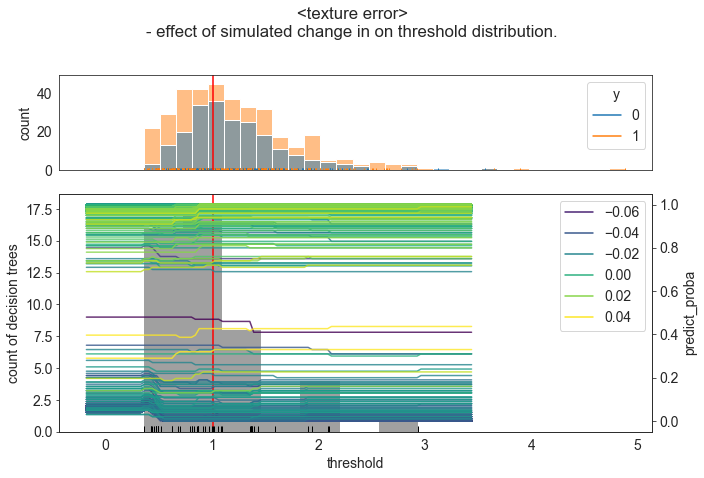

In [334]:
# Low importance example
feature_name = "texture error"
feature_rf_df = df.loc[df.name==feature_name, :]
threshold_std = feature_rf_df.threshold.std()
min_sim = feature_rf_df.threshold.min() - threshold_std
max_sim = feature_rf_df.threshold.max() + threshold_std
step = (max_sim - min_sim) / n_tests
feature_range = np.arange(min_sim, max_sim, step=step)
simulated_df = simulate_results_df(rf, X, feature_name, feature_range)

plot_simulated_change(
    data,
    feature_rf_df,
    simulated_df,
    'threshold',
    feature_name,
)

# Summary

This is a good first look at the inner working of RandomForestClassifier. Being able to see how these algorithms behave under different conditions is a key first step to being able to unbox their workings.

There is still a lot of work to take the thousand of descisions and suface something that is meaningful but this can be used alongside importances to discuss the range of possible effects perturbations might have on the model outcome.

Next steps will be looking how to incorporate importance of the node decision, perhaps using a test set to analyse the number of decision paths it is included in.

Another aim is to look at the relationship with other feature and recreate some kind of partial dependence plots of each feature. We could also look at the upstream decision nodes in relation to our target variable. Are there certain conditions that push the threhold (higher or lower).

I think there is promise to digger a little deeper beyond feature importance for Random Forest. There is lots of opportunity to understand the algorithm and programmaticaly pull out its behaviour whilst keeping its predictive power. We might be able to answer, 'what are the weird scenarios', 'show me the edge cases' and 'how can it break' before putting it in front of customers and without looking through every decision tree. Either way, it's nice to walk in the woods.
